In [754]:
import os
from joblib import Parallel, delayed
import argparse
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from econml.dml import NonParamDML
from matplotlib import pyplot as plt
import warnings
#LGBM version
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
#logistic classifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_predict

from flaml import AutoML
from sklearn.base import BaseEstimator, clone
warnings.simplefilter('ignore')

In [755]:
def gen_data(n,d, base_fn, tau_fn, prop_fn, sigma):
    X = np.random.uniform(0,1, size = (n,d))
    X_test = np.random.uniform(0,1, size = (10000, d)) #regardless of train size, we always use 10000 test samples
    T = np.random.binomial(1, prop_fn(X)) #here, 1 refers to number of trials, 1 reduces the binomial distribution to a bernoulli distribution
    y = (T - .5)*tau_fn(X) + base_fn(X) + sigma*np.random.normal(0,1, size = (n,))
    return y, T, X, X_test

def get_data_generator(n, d, sigma):
        def base_fn(X): return np.sin(np.pi * X[:, 0] * X[:, 1]) + 2*(X[:, 2] - .5)**2 + X[:, 3] + .5*X[:, 4]
        def prop_fn(X): return np.clip(
            np.sin(np.pi * X[:, 0] * X[:, 1]), .2, .8)
        def tau_fn(X):
            return (
                1*(X[:, 0] > 0.7)  # Discontinuous effect
                + 1*(X[:, 1] < 0.3)  # Sparse and counteracting effect
            )
        def gen_data_fn(): return gen_data(
            n, d, base_fn, tau_fn, prop_fn, sigma)
        return gen_data_fn, base_fn, tau_fn, prop_fn

def rmse(ytrue, y):
    return np.sqrt(np.mean((ytrue.flatten() - y.flatten())**2))

def exp(y, T, X, Xtest, method_list, tau_fn, n_x):
    results = {}
    for name, method in method_list:
        tau_est, _ = method(y, T, X, Xtest, n_x)
        results[name] = rmse(tau_fn(Xtest), tau_est)**2 #mse results
        bias = np.mean(tau_est - tau_fn(Xtest)) #average bias over the test set
        var_bias = np.var(tau_est - tau_fn(Xtest)) #variance of the bias
    return results, bias, var_bias

class AutoMLWrap(BaseEstimator):
    def __init__(self, *, model):
        self.model = model
    def fit(self, X, y, **kwargs):
        self.model_ = clone(self.model)
        self.model_.fit(X, y, **kwargs)
        return self
    def predict(self, X):
        return self.model_.predict(X)
    def predict_proba(self, X):
        return self.model_.predict_proba(X)

def first_stage_reg(X, y): #predicting the base response function
    automl = AutoML(task='regression', time_budget=60, early_stop=True,
                    eval_method='cv', n_splits=5, metric='mse', verbose=0)
    automl.fit(X, y)
    best_est = automl.best_estimator 
    return AutoMLWrap(model=clone(automl.best_model_for_estimator(best_est)))

def first_stage_clf(X, y): #predicting the propensities
    automl = AutoML(task='classification', time_budget=60, early_stop=True,
                    eval_method='cv', n_splits=5, metric='mse', verbose=0)
    automl.fit(X, y)
    best_est = automl.best_estimator
    return AutoMLWrap(model=clone(automl.best_model_for_estimator(best_est)))

def weighted_mse(
        X_val, y_val, estimator, labels,
        X_train, y_train, weight_val=None, weight_train=None,
        *args,):
    y_pred = estimator.predict(X_val)
    weight_val = 1 if weight_val is None else weight_val
    weight_train = 1 if weight_train is None else weight_train
    error = (estimator.predict(X_val) - y_val)**2
    val_loss = np.mean(weight_val * error)
    error_train = (estimator.predict(X_train) - y_train)**2
    train_loss = np.mean(weight_train * error_train)
    return val_loss, {"val_loss": val_loss, "train_loss": train_loss}

def final_stage():
    return AutoMLWrap(model=AutoML(task='regression', time_budget=60, early_stop=True,
                                   eval_method='cv',
                                   n_splits=10, metric=weighted_mse, verbose=0))

def dml(y, T, X, Xtest, n_x): #dml with cross-fitting using automl
    est = NonParamDML(model_y='linear',
                      model_t='gbf',
                      model_final=final_stage(),
                      discrete_treatment=True,
                      cv=5,
                      random_state=123)
    est.fit(Y=y, T=T, X=X[:, :n_x], W=X[:, n_x:])
    print("models_t",est.models_t)
    print("models_y",est.models_y)
    return est.effect(Xtest[:, :n_x]), est

def dml_split(y, T, X, Xtest, n_x): #dml with sample splitting using automl
    y1, y2, T1, T2, X1, X2 = train_test_split(
        y, T, X, stratify=T, train_size=.5, random_state=123)
    model_y = first_stage_reg(X1, y1)
    model_y.fit(X1, y1)
    yres = y2 - model_y.predict(X2)
    model_t = first_stage_clf(X1, T1)
    model_t.fit(X1, T1)
    # to avoid division by zero
    Tres = T2 - np.clip(model_t.predict_proba(X2)[:, 1], .001, .999)
    cate = final_stage()
    cate.fit(X2[:, :n_x], yres/Tres, sample_weight=Tres**2)
    return cate.predict(Xtest[:, :n_x]), cate


def dml_split_rf(y, T, X, Xtest, n_x, cv=5): #dml with sample splitting using random forest
    # Split data into two halves
    y1, y2, T1, T2, X1, X2 = train_test_split(
        y, T, X, stratify=T, train_size=0.5
    )
    
    # Cross-validated predictions for y
    model_y = RandomForestRegressor(max_depth=3, min_samples_leaf=30)
    y1_pred = cross_val_predict(model_y, X1, y1, cv=cv)
    model_y.fit(X1, y1)  # Refit on the full training set
    yres = y2 - model_y.predict(X2)  # Residualized outcome
    
    # Cross-validated predictions for T
    model_t = RandomForestClassifier(max_depth=3, min_samples_leaf=30)
    T1_pred = cross_val_predict(model_t, X1, T1, cv=cv, method='predict_proba')[:, 1]
    model_t.fit(X1, T1)  # Refit on the full training set
    Tres = T2 - np.clip(model_t.predict_proba(X2)[:, 1], 0.001, 0.999)  # Residualized treatment
    
    # Fit CATE model using transformed residuals and sample weights
    cate = RandomForestRegressor(max_depth=3, min_samples_leaf=30)
    sample_weight = Tres ** 2
    cate.fit(X2[:, :n_x], yres / Tres, sample_weight=sample_weight)  # R-loss transformation
    cate_pred = cate.predict(Xtest[:, :n_x])  # Predict CATE for test data
    
    return cate_pred, cate


def s_learner(y, T, X, Xtest, n_x):
    model = LGBMRegressor(max_depth=3, min_child_samples=30)
    model.fit(np.hstack((X, T.reshape(-1, 1))), y)
    y0_pred = model.predict(np.hstack((Xtest, np.zeros((Xtest.shape[0], 1)))))
    y1_pred = model.predict(np.hstack((Xtest, np.ones((Xtest.shape[0], 1)))))
    return y1_pred - y0_pred, model


def t_learner(y, T, X, Xtest, n_x):
    # Separate treated and control samples
    X_treated = X[T == 1]
    y_treated = y[T == 1]
    X_control = X[T == 0]
    y_control = y[T == 0]
    # Train separate models
    model_treated = LGBMRegressor(max_depth=3, min_child_samples=30)
    model_control = LGBMRegressor(max_depth=3, min_child_samples=30)
    
    model_treated.fit(X_treated, y_treated)
    model_control.fit(X_control, y_control)
    
    # Predict potential outcomes
    y1_pred = model_treated.predict(Xtest)
    y0_pred = model_control.predict(Xtest)
    
    # Calculate treatment effect
    tau_pred = y1_pred - y0_pred
    
    return tau_pred, (model_treated, model_control)

def s_learner_lasso(y, T, X, Xtest, n_x):
    model = Lasso(alpha = 0.1)
    model.fit(np.hstack((X, T.reshape(-1, 1))), y)
    y0_pred = model.predict(np.hstack((Xtest, np.zeros((Xtest.shape[0], 1)))))
    y1_pred = model.predict(np.hstack((Xtest, np.ones((Xtest.shape[0], 1)))))
    return y1_pred - y0_pred, model

def t_learner_lasso(y, T, X, Xtest, n_x):
    # Separate treated and control samples
    X_treated = X[T == 1]
    y_treated = y[T == 1]
    X_control = X[T == 0]
    y_control = y[T == 0]
    
    # Train separate models
    model_treated = Lasso(alpha = 0.1)
    model_control = Lasso(alpha = 0.1)
    
    model_treated.fit(X_treated, y_treated)
    model_control.fit(X_control, y_control)
    
    # Predict potential outcomes
    y1_pred = model_treated.predict(Xtest)
    y0_pred = model_control.predict(Xtest)
    
    # Calculate treatment effect
    tau_pred = y1_pred - y0_pred
    
    return tau_pred, (model_treated, model_control)

In [756]:
def plot_dgp(get_data_generator):
    # Generate data
    gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(500, 6, 1)
    y, T, X, X_test = gen_data_fn()

    # Create a grid for X[0] and X[1]
    x0 = np.linspace(X[:, 0].min(), X[:, 0].max(), 50)
    x1 = np.linspace(X[:, 1].min(), X[:, 1].max(), 50)
    X0, X1 = np.meshgrid(x0, x1)
    grid = np.column_stack([X0.ravel(), X1.ravel()] + [np.mean(X[:, i]) * np.ones_like(X0.ravel()) for i in range(2, X.shape[1])])

    # Evaluate functions on the grid
    base_vals = base_fn(grid).reshape(X0.shape)
    tau_vals = tau_fn(grid).reshape(X0.shape)
    prop = prop_fn(grid).reshape(X0.shape)

    # Define the figure
    fig = plt.figure(figsize=(20, 6))

    # 3D surface plot for the base function (b_0)
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(X0, X1, base_vals, cmap='viridis', edgecolor='none')
    ax1.set_title('Base Function ($b_0(X)$)')
    ax1.set_xlabel('$X[0]$')
    ax1.set_ylabel('$X[1]$')
    ax1.set_zlabel('$b_0(X)$')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

    # 3D surface plot for the treatment effect (tau_0)
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(X0, X1, tau_vals, cmap='viridis', edgecolor='none')
    ax2.set_title('Treatment Effect Function ($\\tau_0(X)$)')
    ax2.set_xlabel('$X[0]$')
    ax2.set_ylabel('$X[1]$')
    ax2.set_zlabel('$\\tau_0(X)$')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

    # 3D surface plot for propensity + base function
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = ax3.plot_surface(X0, X1, prop, cmap='viridis', edgecolor='none')
    ax3.set_title('Propensity Function ($e_0(X)$)')
    ax3.set_xlabel('$X[0]$')
    ax3.set_ylabel('$X[1]$')
    ax3.set_zlabel('$e_0(X)$')
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)

    # Display the plots
    plt.tight_layout()
    plt.show()

In [757]:
# a function to run all the plots:
def plot_bias(get_data_generator, n_x=4, sigma = 0.5, n= 500, n_simulation = 300):
    gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(n, 6, sigma)
    bias_lst_s = []
    bias_lst_t = []
    bias_lst_dml_split = []
    bias_lst_s2 = []
    bias_lst_t2 = []
    for i in range(n_simulation):
        y, T, X, Xtest = gen_data_fn()
        mse_results, bias, _ = exp(y, T, X, Xtest, [('s-learner', s_learner)], tau_fn, n_x=n_x)
        bias_lst_s.append(bias)
        mse_results, bias, _ = exp(y, T, X, Xtest, [('t-learner', t_learner)], tau_fn, n_x=n_x)
        bias_lst_t.append(bias)
        mse_results, bias, _ = exp(y, T, X, Xtest, [('dml_split', dml_split_rf)], tau_fn, n_x=n_x)
        bias_lst_dml_split.append(bias)
        mse_results, bias, _ = exp(y, T, X, Xtest, [('s-learner', s_learner_lasso)], tau_fn, n_x=n_x)
        bias_lst_s2.append(bias)
        mse_results, bias, _ = exp(y, T, X, Xtest, [('t-learner', t_learner_lasso)], tau_fn, n_x=n_x)
        bias_lst_t2.append(bias)
    #plotting the results bias distributions
    # Plot the results

    mean_bias_s = np.mean(bias_lst_s)
    mean_bias_t = np.mean(bias_lst_t)
    mean_bias_dml_split = np.mean(bias_lst_dml_split)
    mean_bias_s2 = np.mean(bias_lst_s2)
    mean_bias_t2 = np.mean(bias_lst_t2)

    #t-test whether mean bias is significantly different from 0
    from scipy.stats import ttest_1samp
    t_stat_s, p_value_s = ttest_1samp(bias_lst_s, 0)
    t_stat_t, p_value_t = ttest_1samp(bias_lst_t, 0)
    t_stat_dml_split, p_value_dml_split = ttest_1samp(bias_lst_dml_split, 0)
    t_stat_s2, p_value_s2 = ttest_1samp(bias_lst_s2, 0)
    t_stat_t2, p_value_t2 = ttest_1samp(bias_lst_t2, 0)

    # Create a 2*2 single figure with two horizontal subplots apart from dml results
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes[0,0].set_xlim(-0.6, 0.6)
    axes[0,1].set_xlim(-0.6, 0.6)
    axes[1,0].set_xlim(-0.6, 0.6)
    axes[1,1].set_xlim(-0.6, 0.6)

    # S-Learner Bias Distribution
    axes[0,0].hist(bias_lst_s, bins=50, density=True, alpha=0.7, label="Simulation")
    axes[0,0].axvline(x=mean_bias_s, color='orange', linestyle='-', label="Mean Bias Across Simulations")
    axes[0,0].set_title("Bias in Estimated Causal Effect (S-Learner - LGBM)")
    axes[0,0].text(0.05, 0.1, f"p-value = {p_value_s:.3f}", transform=axes[0,0].transAxes)

    # T-Learner Bias Distribution
    axes[0,1].hist(bias_lst_t, bins=50, density=True, alpha=0.7, label="Simulation")
    axes[0,1].axvline(x=mean_bias_t, color='orange', linestyle='-', label="Mean Bias Across Simulations")
    axes[0,1].set_title("Bias in Estimated Causal Effect (T-Learner - LGBM)")
    axes[0,1].text(0.05, 0.1, f"p-value = {p_value_t:.3f}", transform=axes[0,1].transAxes)

    # S-Learner Lasso Bias Distribution
    axes[1,0].hist(bias_lst_s2, bins=50, density=True, alpha=0.7, label="Simulation")
    axes[1,0].axvline(x=mean_bias_s2, color='orange', linestyle='-', label="Mean Bias Across Simulations")
    axes[1,0].set_title("Bias in Estimated Causal Effect (S-Learner - Lasso)")
    axes[1,0].text(0.05, 0.1, f"p-value = {p_value_s2:.3f}", transform=axes[1,0].transAxes)

    # T-Learner Lasso Bias Distribution
    axes[1,1].hist(bias_lst_t2, bins=50, density=True, alpha=0.7, label="Simulation")
    axes[1,1].axvline(x=mean_bias_t2, color='orange', linestyle='-', label="Mean Bias Across Simulations")
    axes[1,1].set_title("Bias in Estimated Causal Effect (T-Learner - Lasso)")
    axes[1,1].text(0.05, 0.1, f"p-value = {p_value_t2:.3f}", transform=axes[1,1].transAxes)

    for i in range(2):
        for j in range(2):
            axes[i,j].axvline(x=0, color='blue', linestyle='--', label="Zero Bias")
            axes[i,j].set_xlabel(r"$\tau - \hat{\tau}$")
            axes[i,j].set_ylabel("Density")
            axes[i,j].legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

    # Create a single figure for dml
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))
    axes.set_xlim(-0.6, 0.6)
    axes.hist(bias_lst_dml_split, bins=50, density=True, alpha=0.7, label="Simulation")
    axes.axvline(x=0, color='blue', linestyle='--', label="Zero Bias")
    axes.axvline(x=mean_bias_dml_split, color='orange', linestyle='-', label="Mean Bias Across Simulations")
    axes.set_title("Bias in Estimated Causal Effect (Orthogonal Learner - Random Forest with R - Loss)")
    axes.set_xlabel(r"$\tau - \hat{\tau}$")
    axes.set_ylabel("Density")
    axes.legend()
    axes.text(0.05, 0.1, f"p-value = {p_value_dml_split:.3f}", transform=axes.transAxes)
    plt.tight_layout()
    plt.show()

In [758]:
def plot_convergence(n_list = range(300, 3000, 200), n_simulation=15, sigma = 0.5):
    # Initialize results
    results = {"mse_s": [], "mse_t": [], "bias_s": [], "bias_t": [], "var_s": [], "var_t": [],
            "mse_s2": [], "mse_t2": [], "bias_s2": [], "bias_t2": [], "var_s2": [], "var_t2": [],
            "mse_dml": [], "bias_dml": [], "var_dml": []}

    for n in n_list:
        # Temporary storage for simulations
        temp_results = {"s": {"mse": [], "bias": [], "var": []}, "t": {"mse": [], "bias": [], "var": []},
                        "s2": {"mse": [], "bias": [], "var": []}, "t2": {"mse": [], "bias": [], "var": []},
                        "dml": {"mse": [], "bias": [], "var": []}}

        for _ in range(n_simulation):
            gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(n, 6, 0.5)
            y, T, X, Xtest = gen_data_fn()

            # S-Learner
            mse_s, bias_s, var_s = exp(y, T, X, Xtest, [('s-learner', s_learner)], tau_fn, n_x=4)
            temp_results["s"]["mse"].append(mse_s['s-learner'])
            temp_results["s"]["bias"].append(bias_s)
            temp_results["s"]["var"].append(var_s)

            # T-Learner
            mse_t, bias_t, var_t = exp(y, T, X, Xtest, [('t-learner', t_learner)], tau_fn, n_x=4)
            temp_results["t"]["mse"].append(mse_t['t-learner'])
            temp_results["t"]["bias"].append(bias_t)
            temp_results["t"]["var"].append(var_t)

            # S-Learner with Lasso
            mse_s2, bias_s2, var_s2 = exp(y, T, X, Xtest, [('s-learner', s_learner_lasso)], tau_fn, n_x=4)
            temp_results["s2"]["mse"].append(mse_s2['s-learner'])
            temp_results["s2"]["bias"].append(bias_s2)
            temp_results["s2"]["var"].append(var_s2)

            # T-Learner with Lasso
            mse_t2, bias_t2, var_t2 = exp(y, T, X, Xtest, [('t-learner', t_learner_lasso)], tau_fn, n_x=4)
            temp_results["t2"]["mse"].append(mse_t2['t-learner'])
            temp_results["t2"]["bias"].append(bias_t2)
            temp_results["t2"]["var"].append(var_t2)

            # Double ML
            mse_dml, bias_dml, var_dml = exp(y, T, X, Xtest, [('dml', dml_split_rf)], tau_fn, n_x=4)
            temp_results["dml"]["mse"].append(mse_dml['dml'])
            temp_results["dml"]["bias"].append(bias_dml)
            temp_results["dml"]["var"].append(var_dml)

        # Aggregate results for current sample size
        results["mse_s"].append(np.mean(temp_results["s"]["mse"]))
        results["mse_t"].append(np.mean(temp_results["t"]["mse"]))
        results["bias_s"].append(np.mean(temp_results["s"]["bias"]))
        results["bias_t"].append(np.mean(temp_results["t"]["bias"]))
        results["var_s"].append(np.mean(temp_results["s"]["var"]))
        results["var_t"].append(np.mean(temp_results["t"]["var"]))
        results["mse_s2"].append(np.mean(temp_results["s2"]["mse"]))
        results["mse_t2"].append(np.mean(temp_results["t2"]["mse"]))
        results["bias_s2"].append(np.mean(temp_results["s2"]["bias"]))
        results["bias_t2"].append(np.mean(temp_results["t2"]["bias"]))
        results["var_s2"].append(np.mean(temp_results["s2"]["var"]))
        results["var_t2"].append(np.mean(temp_results["t2"]["var"]))
        results["mse_dml"].append(np.mean(temp_results["dml"]["mse"]))
        results["bias_dml"].append(np.mean(temp_results["dml"]["bias"]))
        results["var_dml"].append(np.mean(temp_results["dml"]["var"]))

    # Plot the results in a single figure vertically
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))

    # Define plot parameters
    metrics = ["mse", "bias", "var"]
    titles = [
        "MSE of CATE Estimation",
        "Bias in CATE Estimation",
        "Variance in CATE Estimation Bias",
    ]
    ylabels = ["MSE", "Average Bias", "Average Variance in Bias"]

    # Iterate over metrics to plot
    for i, metric in enumerate(metrics):
        axes[i].plot(n_list, results[f"{metric}_s"], label="S-Learner-LGBM", color = 'green', linestyle = '-',alpha=0.5)
        axes[i].plot(n_list, results[f"{metric}_t"], label="T-Learner-LGBM", color = 'steelblue', linestyle = '-',alpha=0.5)
        axes[i].plot(n_list, results[f"{metric}_s2"], label="S-Learner-Lasso", color = 'orange', linestyle = '-',alpha=0.5)
        axes[i].plot(n_list, results[f"{metric}_t2"], label="T-Learner-Lasso",  color = 'purple', linestyle = '-',alpha=0.5)
        axes[i].axhline(y=0 if metric != "mse" else 0, color='gray', linestyle='--', alpha=0.5)
        axes[i].plot(n_list, results[f"{metric}_dml"], label="Orthogonal Learner (R-Loss)", color = 'red', linestyle = '-', linewidth = 2)
        axes[i].set_title(titles[i])
        axes[i].set_xlabel("Training Size")
        axes[i].set_ylabel(ylabels[i])
        axes[i].legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

    #plot without orthogonal learner
    # Plot the results in a single figure vertically
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))

    # Define plot parameters
    metrics = ["mse", "bias", "var"]
    titles = [
        "MSE of CATE Estimation",
        "Bias in CATE Estimation",
        "Variance in CATE Estimation Bias",
    ]
    ylabels = ["MSE", "Average Bias", "Average Variance in Bias"]

    # Iterate over metrics to plot
    for i, metric in enumerate(metrics):
        axes[i].plot(n_list, results[f"{metric}_s"], label="S-Learner-LGBM", color = 'green', linestyle = '-',alpha=0.5)
        axes[i].plot(n_list, results[f"{metric}_t"], label="T-Learner-LGBM", color = 'steelblue', linestyle = '-',alpha=0.5)
        axes[i].plot(n_list, results[f"{metric}_s2"], label="S-Learner-Lasso", color = 'orange', linestyle = '-',alpha=0.5)
        axes[i].plot(n_list, results[f"{metric}_t2"], label="T-Learner-Lasso",  color = 'purple', linestyle = '-',alpha=0.5)
        axes[i].axhline(y=0 if metric != "mse" else 0, color='gray', linestyle='--', alpha=0.5)
        axes[i].set_title(titles[i])
        axes[i].set_xlabel("Training Size")
        axes[i].set_ylabel(ylabels[i])
        axes[i].legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

    stored_results = results
    print(stored_results)

    return stored_results

# Use Cases

In [759]:
gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(3000, 6, 0.5)
y, T, X, Xtest = gen_data_fn()
print(y.shape, T.shape, X.shape, Xtest.shape)
exp(y, T, X, Xtest, [('dml_split', dml_split_rf),('t-learner',t_learner),('s-learner',s_learner)], tau_fn, n_x=4)

(3000,) (3000,) (3000, 6) (10000, 6)


({'dml_split': 0.03847598789568024,
  't-learner': 0.04822259485837379,
  's-learner': 0.052231801913784216},
 0.018884753695840188,
 0.051875167991631665)

# DGP

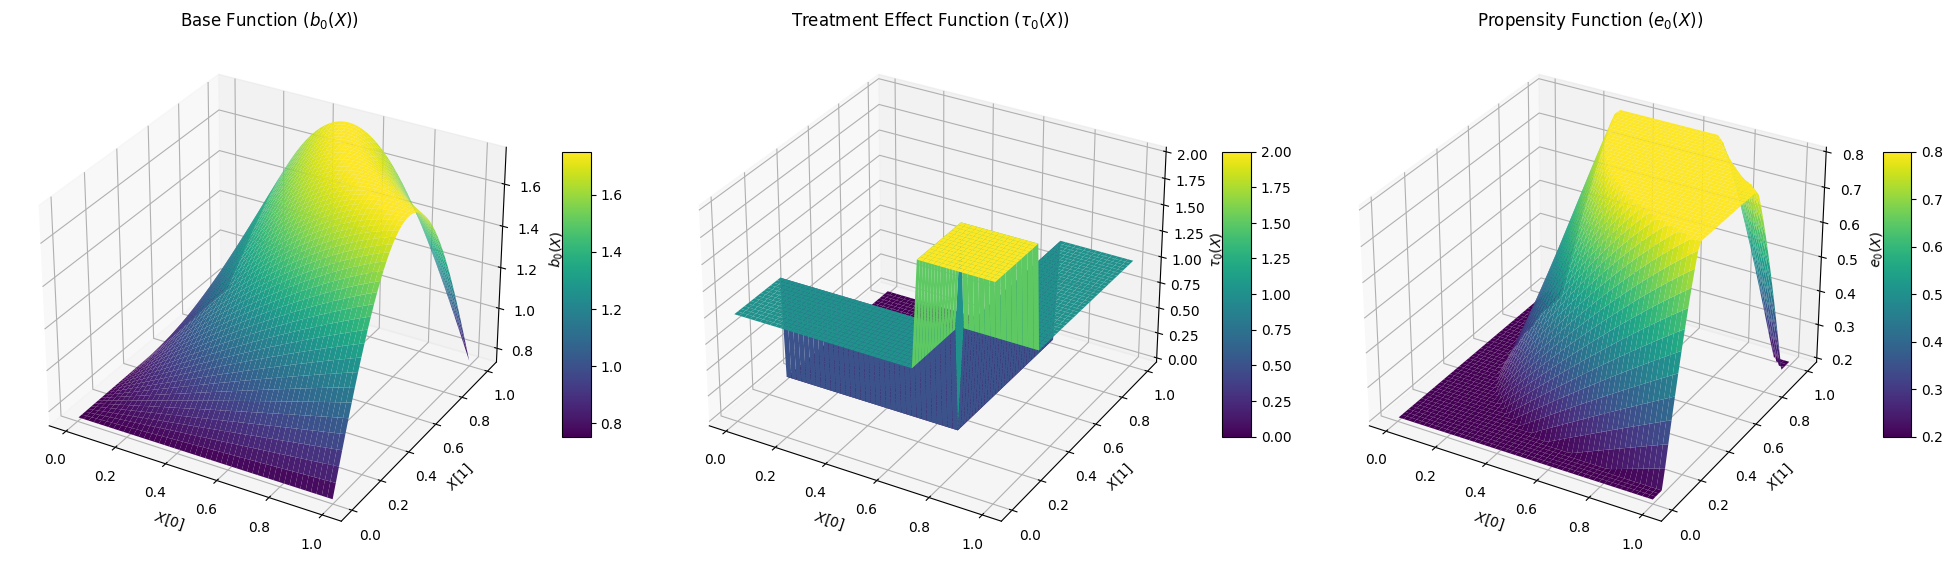

In [760]:
plot_dgp(get_data_generator)

# Bias Comparison

In [761]:
plot_bias(get_data_generator, n_x=4, sigma = 0.5, n= 500, n_simulation = 300)

simulated N =  0
simulated N =  10
simulated N =  20
simulated N =  30
simulated N =  40
simulated N =  50
simulated N =  60
simulated N =  70
simulated N =  80
simulated N =  90
simulated N =  100
simulated N =  110
simulated N =  120
simulated N =  130
simulated N =  140
simulated N =  150
simulated N =  160
simulated N =  170
simulated N =  180
simulated N =  190
simulated N =  200
simulated N =  210
simulated N =  220
simulated N =  230
simulated N =  240
simulated N =  250
simulated N =  260
simulated N =  270
simulated N =  280
simulated N =  290
S-Learner: t-statistic = -14.78645231456486, p-value = 1.6395537804899397e-37
T-Learner: t-statistic = 1.0193265303626298, p-value = 0.30887202615859755


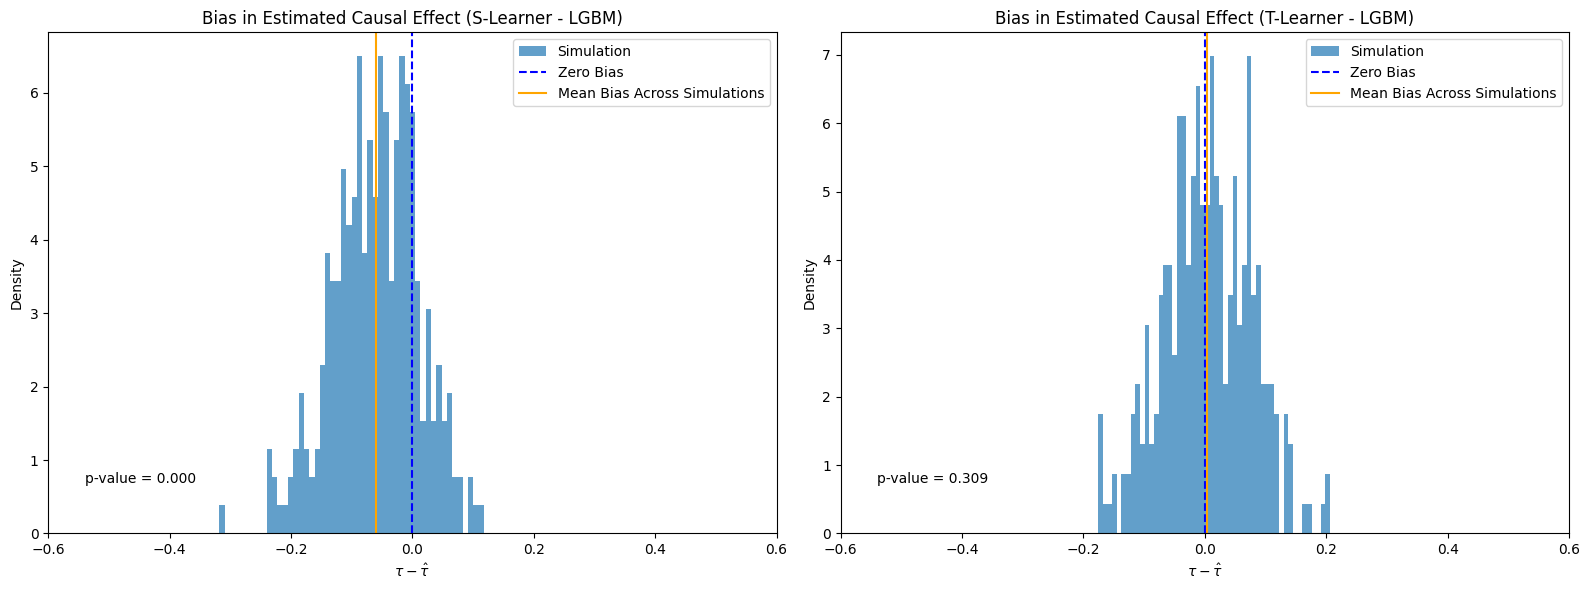

In [457]:
gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(1000, 6, 0.5)
n_simulation = 300
bias_lst_s = []
bias_lst_t = []
for i in range(n_simulation):
    y, T, X, Xtest = gen_data_fn()
    mse_results, bias, _ = exp(y, T, X, Xtest, [('s-learner', s_learner)], tau_fn, n_x=4) #use lgbm regressor
    bias_lst_s.append(bias)
    mse_results, bias, _ = exp(y, T, X, Xtest, [('t-learner', t_learner)], tau_fn, n_x=4) #use lgbm regressor
    bias_lst_t.append(bias)
    if i % 10 == 0:
        print('simulated N = ',i)
#plotting the results bias distributions
# Plot the results

mean_bias_s = np.mean(bias_lst_s)
mean_bias_t = np.mean(bias_lst_t)

# Create a single figure with two horizontal subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#set x-axis limits to -0.6 to 0.6
axes[0].set_xlim(-0.6, 0.6)
axes[1].set_xlim(-0.6, 0.6)

# S-Learner Bias Distribution
axes[0].hist(bias_lst_s, bins=50, density=True, alpha=0.7, label="Simulation")
axes[0].axvline(x=0, color='blue', linestyle='--', label="Zero Bias")
axes[0].axvline(x=mean_bias_s, color='orange', linestyle='-', label="Mean Bias Across Simulations")
axes[0].set_title("Bias in Estimated Causal Effect (S-Learner - LGBM)")
axes[0].set_xlabel(r"$\tau - \hat{\tau}$")
axes[0].set_ylabel("Density")
axes[0].legend()

# T-Learner Bias Distribution
axes[1].hist(bias_lst_t, bins=50, density=True, alpha=0.7, label="Simulation")
axes[1].axvline(x=0, color='blue', linestyle='--', label="Zero Bias")
axes[1].axvline(x=mean_bias_t, color='orange', linestyle='-', label="Mean Bias Across Simulations")
axes[1].set_title("Bias in Estimated Causal Effect (T-Learner - LGBM)")
axes[1].set_xlabel(r"$\tau - \hat{\tau}$")
axes[1].set_ylabel("Density")
axes[1].legend()


#t-test whether mean bias is significantly different from 0
from scipy.stats import ttest_1samp
t_stat_s, p_value_s = ttest_1samp(bias_lst_s, 0)
t_stat_t, p_value_t = ttest_1samp(bias_lst_t, 0)
print(f"S-Learner: t-statistic = {t_stat_s}, p-value = {p_value_s}")
print(f"T-Learner: t-statistic = {t_stat_t}, p-value = {p_value_t}")

#add text annotation of p-value
axes[0].text(0.05, 0.1, f"p-value = {p_value_s:.3f}", transform=axes[0].transAxes)
axes[1].text(0.05, 0.1, f"p-value = {p_value_t:.3f}", transform=axes[1].transAxes)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

simulated N =  0
simulated N =  10
simulated N =  20
simulated N =  30
simulated N =  40
simulated N =  50
simulated N =  60
simulated N =  70
simulated N =  80
simulated N =  90
simulated N =  100
simulated N =  110
simulated N =  120
simulated N =  130
simulated N =  140
simulated N =  150
simulated N =  160
simulated N =  170
simulated N =  180
simulated N =  190
simulated N =  200
simulated N =  210
simulated N =  220
simulated N =  230
simulated N =  240
simulated N =  250
simulated N =  260
simulated N =  270
simulated N =  280
simulated N =  290
S-Learner: t-statistic = -84.46381984723843, p-value = 1.1096999268981966e-210
T-Learner: t-statistic = 1.8234791446969476, p-value = 0.06922913556589058


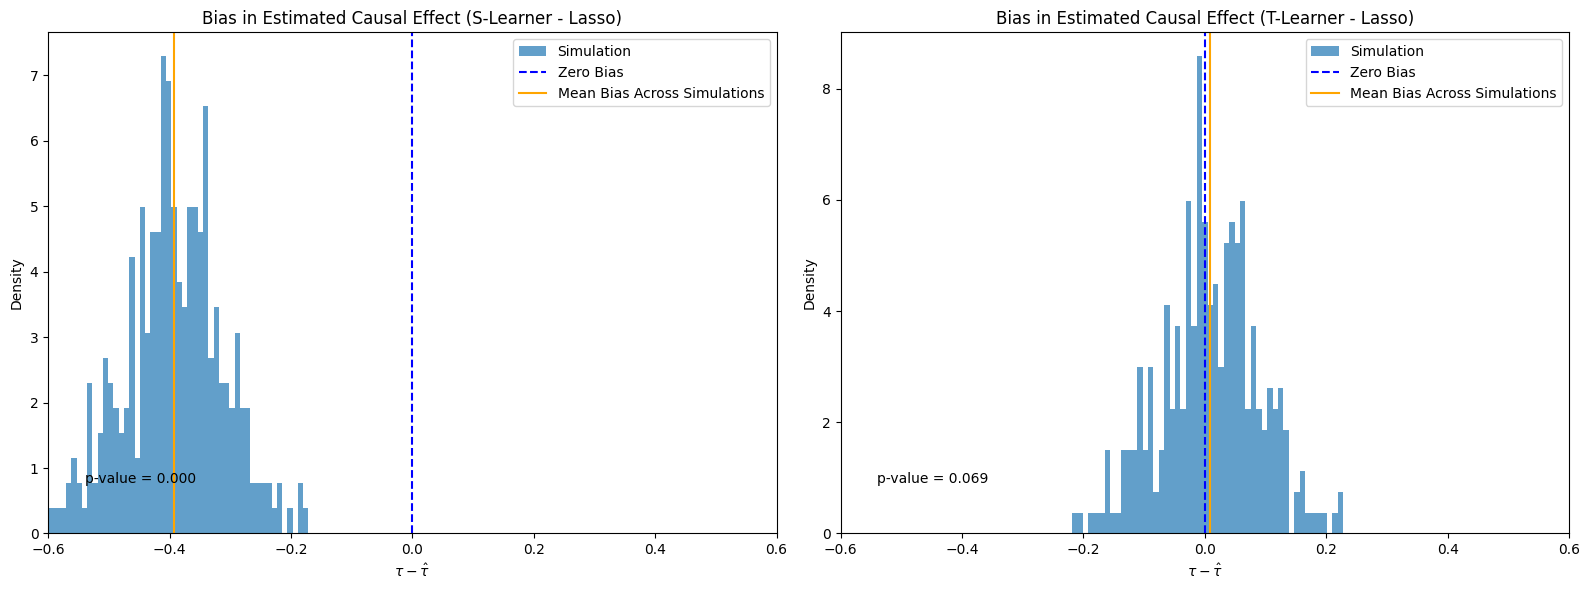

In [458]:
gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(1000, 6, 0.5)
n_simulation = 300
bias_lst_s = []
bias_lst_t = []
for i in range(n_simulation):
    y, T, X, Xtest = gen_data_fn()
    mse_results, bias, _ = exp(y, T, X, Xtest, [('s-learner', s_learner_lasso)], tau_fn, n_x=4) #use lgbm regressor
    bias_lst_s.append(bias)
    mse_results, bias, _ = exp(y, T, X, Xtest, [('t-learner', t_learner_lasso)], tau_fn, n_x=4) #use lgbm regressor
    bias_lst_t.append(bias)
    if i % 10 == 0:
        print('simulated N = ',i)
#plotting the results bias distributions
# Plot the results

mean_bias_s = np.mean(bias_lst_s)
mean_bias_t = np.mean(bias_lst_t)

# Create a single figure with two horizontal subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].set_xlim(-0.6, 0.6)
axes[1].set_xlim(-0.6, 0.6)

# S-Learner Bias Distribution
axes[0].hist(bias_lst_s, bins=50, density=True, alpha=0.7, label="Simulation")
axes[0].axvline(x=0, color='blue', linestyle='--', label="Zero Bias")
axes[0].axvline(x=mean_bias_s, color='orange', linestyle='-', label="Mean Bias Across Simulations")
axes[0].set_title("Bias in Estimated Causal Effect (S-Learner - Lasso)")
axes[0].set_xlabel(r"$\tau - \hat{\tau}$")
axes[0].set_ylabel("Density")
axes[0].legend()

# T-Learner Bias Distribution
axes[1].hist(bias_lst_t, bins=50, density=True, alpha=0.7, label="Simulation")
axes[1].axvline(x=0, color='blue', linestyle='--', label="Zero Bias")
axes[1].axvline(x=mean_bias_t, color='orange', linestyle='-', label="Mean Bias Across Simulations")
axes[1].set_title("Bias in Estimated Causal Effect (T-Learner - Lasso)")
axes[1].set_xlabel(r"$\tau - \hat{\tau}$")
axes[1].set_ylabel("Density")
axes[1].legend()

#t-test whether mean bias is significantly different from 0
from scipy.stats import ttest_1samp
t_stat_s, p_value_s = ttest_1samp(bias_lst_s, 0)
t_stat_t, p_value_t = ttest_1samp(bias_lst_t, 0)
print(f"S-Learner: t-statistic = {t_stat_s}, p-value = {p_value_s}")
print(f"T-Learner: t-statistic = {t_stat_t}, p-value = {p_value_t}")

#add text annotation of p-value
axes[0].text(0.05, 0.1, f"p-value = {p_value_s:.3f}", transform=axes[0].transAxes)
axes[1].text(0.05, 0.1, f"p-value = {p_value_t:.3f}", transform=axes[1].transAxes)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


DML Split: t-statistic = 3.3552747840876282, p-value = 0.0008951885995000589


Text(0.05, 0.1, 'p-value = 0.001')

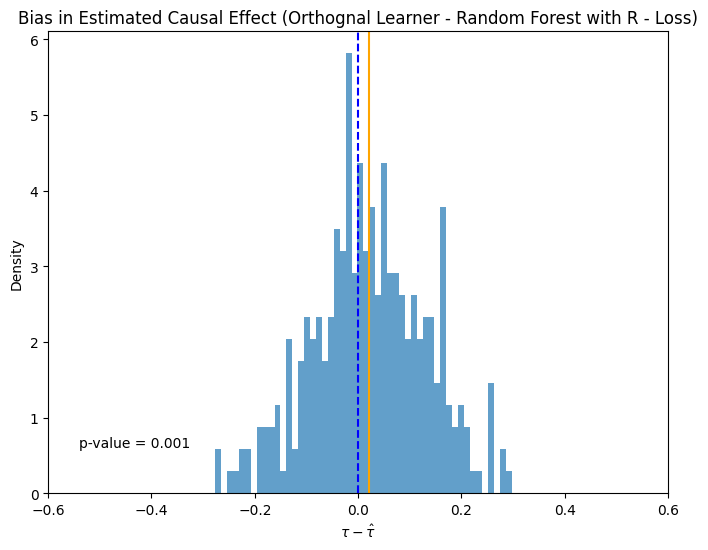

In [456]:
#bias in dml estimator
gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(1000, 6, 0.5)
n_simulation = 300
bias_lst_dml_split = []

for i in range(n_simulation):
    y, T, X, Xtest = gen_data_fn()
    mse_results, bias, _ = exp(y, T, X, Xtest, [('dml_split', dml_split_rf)], tau_fn, n_x=4)
    bias_lst_dml_split.append(bias)

mean_bias_dml_split = np.mean(bias_lst_dml_split)

# Create a single figure with two horizontal subplots
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.set_xlim(-0.6, 0.6)

# DML Split Bias Distribution
axes.hist(bias_lst_dml_split, bins=50, density=True, alpha=0.7, label="Simulation")
axes.axvline(x=0, color='blue', linestyle='--', label="Zero Bias")
axes.axvline(x=mean_bias_dml_split, color='orange', linestyle='-', label="Mean Bias Across Simulations")
axes.set_title("Bias in Estimated Causal Effect (Orthognal Learner - Random Forest with R - Loss)")
axes.set_xlabel(r"$\tau - \hat{\tau}$")
axes.set_ylabel("Density")

#t-test whether mean bias is significantly different from 0
from scipy.stats import ttest_1samp
t_stat_dml_split, p_value_dml_split = ttest_1samp(bias_lst_dml_split, 0)
print(f"DML Split: t-statistic = {t_stat_dml_split}, p-value = {p_value_dml_split}")

#add text annotation of p-value
axes.text(0.05, 0.1, f"p-value = {p_value_dml_split:.3f}", transform=axes.transAxes)


# Convergence rate

In [ ]:
plot_convergence(n_list = range(300, 3000, 200), n_simulation=15, sigma = 0.5)

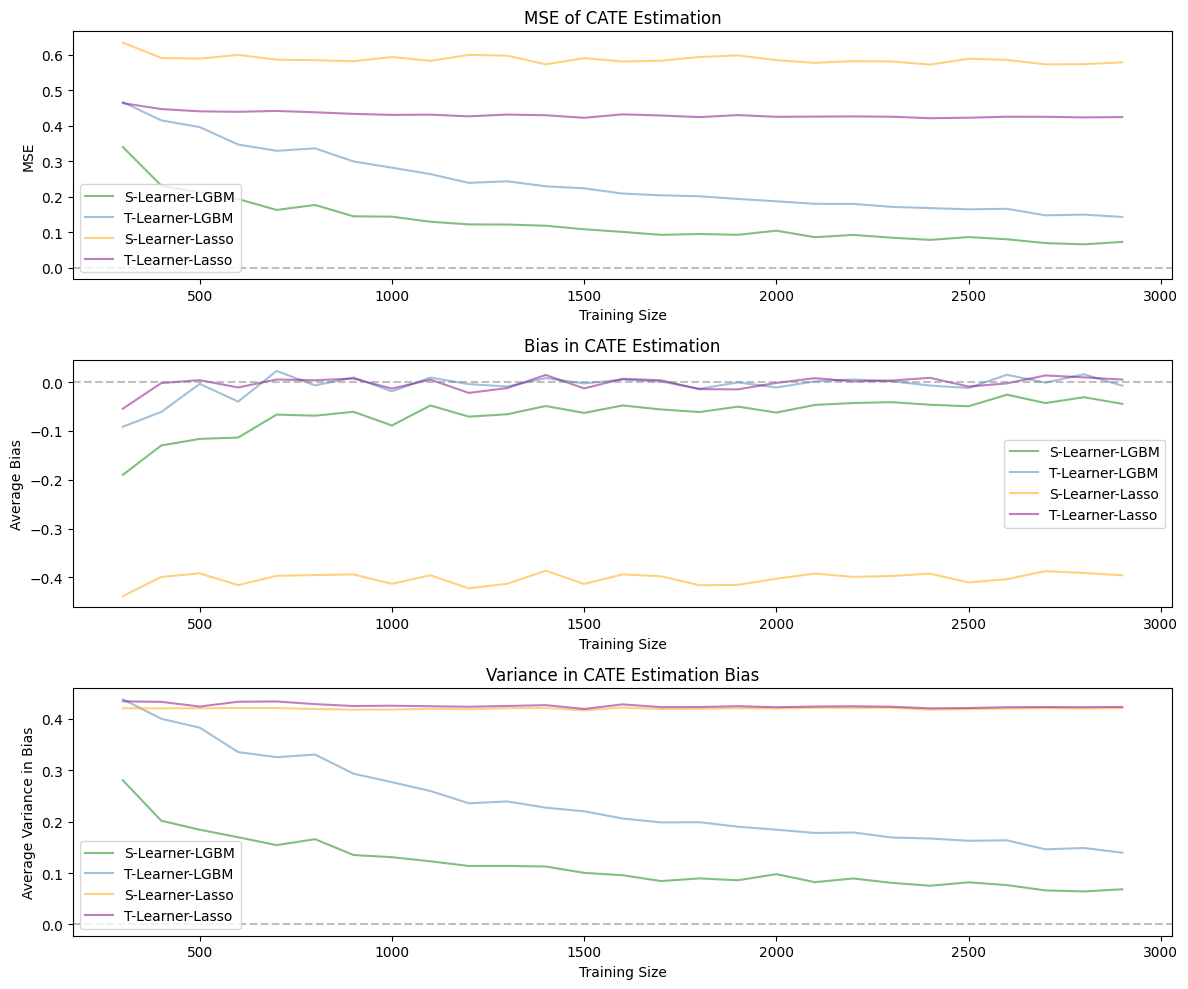

In [453]:
# Convergence rate analysis
n_list = range(300, 3000, 100)
n_simulation = 20

# Initialize results
results = {"mse_s": [], "mse_t": [], "bias_s": [], "bias_t": [], "var_s": [], "var_t": [],
           "mse_s2": [], "mse_t2": [], "bias_s2": [], "bias_t2": [], "var_s2": [], "var_t2": []}

for n in n_list:
    # Temporary storage for simulations
    temp_results = {"s": {"mse": [], "bias": [], "var": []}, "t": {"mse": [], "bias": [], "var": []},
                    "s2": {"mse": [], "bias": [], "var": []}, "t2": {"mse": [], "bias": [], "var": []}}

    for _ in range(n_simulation):
        gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(n, 6, 0.5)
        y, T, X, Xtest = gen_data_fn()

        # S-Learner
        mse_s, bias_s, var_s = exp(y, T, X, Xtest, [('s-learner', s_learner)], tau_fn, n_x=4)
        temp_results["s"]["mse"].append(mse_s['s-learner'])
        temp_results["s"]["bias"].append(bias_s)
        temp_results["s"]["var"].append(var_s)

        # T-Learner
        mse_t, bias_t, var_t = exp(y, T, X, Xtest, [('t-learner', t_learner)], tau_fn, n_x=4)
        temp_results["t"]["mse"].append(mse_t['t-learner'])
        temp_results["t"]["bias"].append(bias_t)
        temp_results["t"]["var"].append(var_t)

        # S-Learner with Lasso
        mse_s2, bias_s2, var_s2 = exp(y, T, X, Xtest, [('s-learner', s_learner_lasso)], tau_fn, n_x=4)
        temp_results["s2"]["mse"].append(mse_s2['s-learner'])
        temp_results["s2"]["bias"].append(bias_s2)
        temp_results["s2"]["var"].append(var_s2)

        # T-Learner with Lasso
        mse_t2, bias_t2, var_t2 = exp(y, T, X, Xtest, [('t-learner', t_learner_lasso)], tau_fn, n_x=4)
        temp_results["t2"]["mse"].append(mse_t2['t-learner'])
        temp_results["t2"]["bias"].append(bias_t2)
        temp_results["t2"]["var"].append(var_t2)

    # Aggregate results for current sample size
    results["mse_s"].append(np.mean(temp_results["s"]["mse"]))
    results["mse_t"].append(np.mean(temp_results["t"]["mse"]))
    results["bias_s"].append(np.mean(temp_results["s"]["bias"]))
    results["bias_t"].append(np.mean(temp_results["t"]["bias"]))
    results["var_s"].append(np.mean(temp_results["s"]["var"]))
    results["var_t"].append(np.mean(temp_results["t"]["var"]))
    results["mse_s2"].append(np.mean(temp_results["s2"]["mse"]))
    results["mse_t2"].append(np.mean(temp_results["t2"]["mse"]))
    results["bias_s2"].append(np.mean(temp_results["s2"]["bias"]))
    results["bias_t2"].append(np.mean(temp_results["t2"]["bias"]))
    results["var_s2"].append(np.mean(temp_results["s2"]["var"]))
    results["var_t2"].append(np.mean(temp_results["t2"]["var"]))


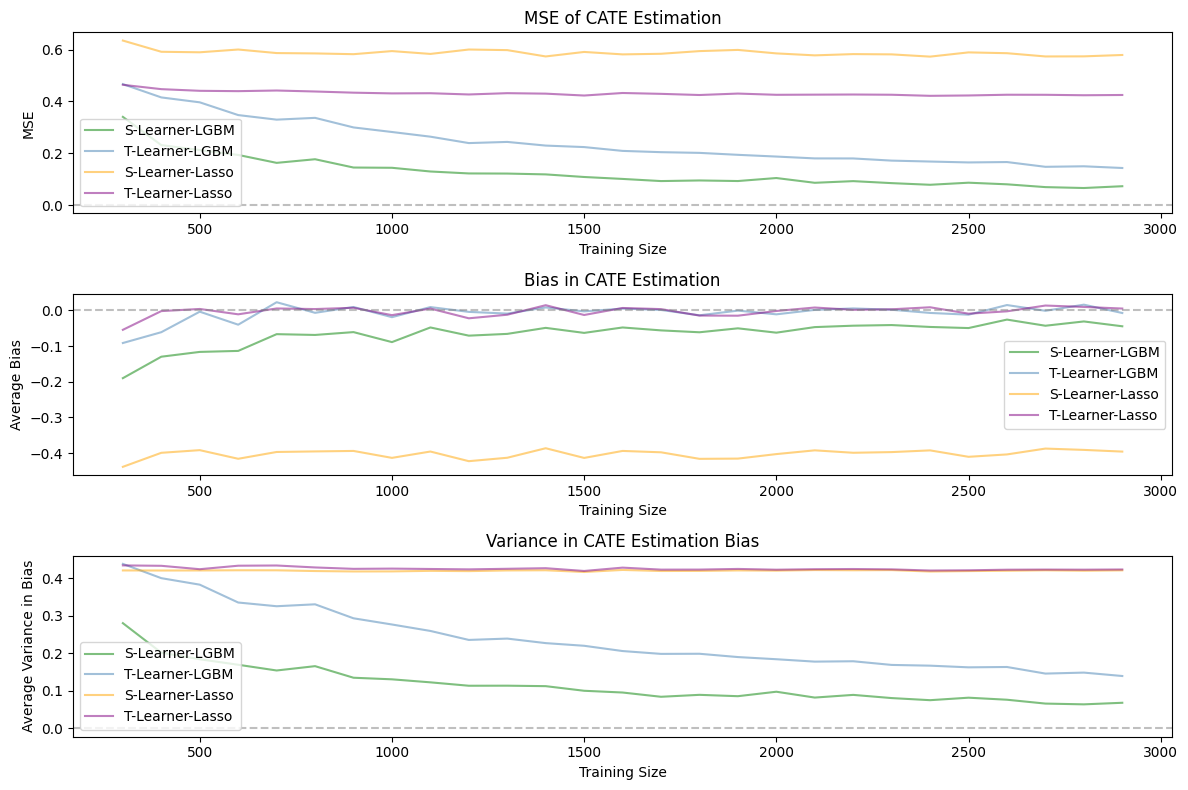

In [459]:

# Plot the results in a single figure vertically
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Define plot parameters
metrics = ["mse", "bias", "var"]
titles = [
    "MSE of CATE Estimation",
    "Bias in CATE Estimation",
    "Variance in CATE Estimation Bias",
]
ylabels = ["MSE", "Average Bias", "Average Variance in Bias"]

# Iterate over metrics to plot
for i, metric in enumerate(metrics):
    axes[i].plot(n_list, results[f"{metric}_s"], label="S-Learner-LGBM", color = 'green', linestyle = '-',alpha=0.5)
    axes[i].plot(n_list, results[f"{metric}_t"], label="T-Learner-LGBM", color = 'steelblue', linestyle = '-',alpha=0.5)
    axes[i].plot(n_list, results[f"{metric}_s2"], label="S-Learner-Lasso", color = 'orange', linestyle = '-',alpha=0.5)
    axes[i].plot(n_list, results[f"{metric}_t2"], label="T-Learner-Lasso",  color = 'purple', linestyle = '-',alpha=0.5)
    axes[i].axhline(y=0 if metric != "mse" else 0, color='gray', linestyle='--', alpha=0.5)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Training Size")
    axes[i].set_ylabel(ylabels[i])
    axes[i].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [736]:
# Add Double ML results (Orthogonal Learning with R-loss)
n_list = range(300, 3000, 200)
n_simulation = 15


# Initialize results
results = {"mse_s": [], "mse_t": [], "bias_s": [], "bias_t": [], "var_s": [], "var_t": [],
           "mse_s2": [], "mse_t2": [], "bias_s2": [], "bias_t2": [], "var_s2": [], "var_t2": [],
           "mse_dml": [], "bias_dml": [], "var_dml": []}

for n in n_list:
    # Temporary storage for simulations
    temp_results = {"s": {"mse": [], "bias": [], "var": []}, "t": {"mse": [], "bias": [], "var": []},
                    "s2": {"mse": [], "bias": [], "var": []}, "t2": {"mse": [], "bias": [], "var": []},
                    "dml": {"mse": [], "bias": [], "var": []}}

    for _ in range(n_simulation):
        gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(n, 6, 0.5)
        y, T, X, Xtest = gen_data_fn()

        # S-Learner
        mse_s, bias_s, var_s = exp(y, T, X, Xtest, [('s-learner', s_learner)], tau_fn, n_x=4)
        temp_results["s"]["mse"].append(mse_s['s-learner'])
        temp_results["s"]["bias"].append(bias_s)
        temp_results["s"]["var"].append(var_s)

        # T-Learner
        mse_t, bias_t, var_t = exp(y, T, X, Xtest, [('t-learner', t_learner)], tau_fn, n_x=4)
        temp_results["t"]["mse"].append(mse_t['t-learner'])
        temp_results["t"]["bias"].append(bias_t)
        temp_results["t"]["var"].append(var_t)

        # S-Learner with Lasso
        mse_s2, bias_s2, var_s2 = exp(y, T, X, Xtest, [('s-learner', s_learner_lasso)], tau_fn, n_x=4)
        temp_results["s2"]["mse"].append(mse_s2['s-learner'])
        temp_results["s2"]["bias"].append(bias_s2)
        temp_results["s2"]["var"].append(var_s2)

        # T-Learner with Lasso
        mse_t2, bias_t2, var_t2 = exp(y, T, X, Xtest, [('t-learner', t_learner_lasso)], tau_fn, n_x=4)
        temp_results["t2"]["mse"].append(mse_t2['t-learner'])
        temp_results["t2"]["bias"].append(bias_t2)
        temp_results["t2"]["var"].append(var_t2)

        # Double ML
        mse_dml, bias_dml, var_dml = exp(y, T, X, Xtest, [('dml', dml_split_rf)], tau_fn, n_x=4)
        temp_results["dml"]["mse"].append(mse_dml['dml'])
        temp_results["dml"]["bias"].append(bias_dml)
        temp_results["dml"]["var"].append(var_dml)


    # Aggregate results for current sample size
    results["mse_s"].append(np.mean(temp_results["s"]["mse"]))
    results["mse_t"].append(np.mean(temp_results["t"]["mse"]))
    results["bias_s"].append(np.mean(temp_results["s"]["bias"]))
    results["bias_t"].append(np.mean(temp_results["t"]["bias"]))
    results["var_s"].append(np.mean(temp_results["s"]["var"]))
    results["var_t"].append(np.mean(temp_results["t"]["var"]))
    results["mse_s2"].append(np.mean(temp_results["s2"]["mse"]))
    results["mse_t2"].append(np.mean(temp_results["t2"]["mse"]))
    results["bias_s2"].append(np.mean(temp_results["s2"]["bias"]))
    results["bias_t2"].append(np.mean(temp_results["t2"]["bias"]))
    results["var_s2"].append(np.mean(temp_results["s2"]["var"]))
    results["var_t2"].append(np.mean(temp_results["t2"]["var"]))
    results["mse_dml"].append(np.mean(temp_results["dml"]["mse"]))
    results["bias_dml"].append(np.mean(temp_results["dml"]["bias"]))
    results["var_dml"].append(np.mean(temp_results["dml"]["var"]))


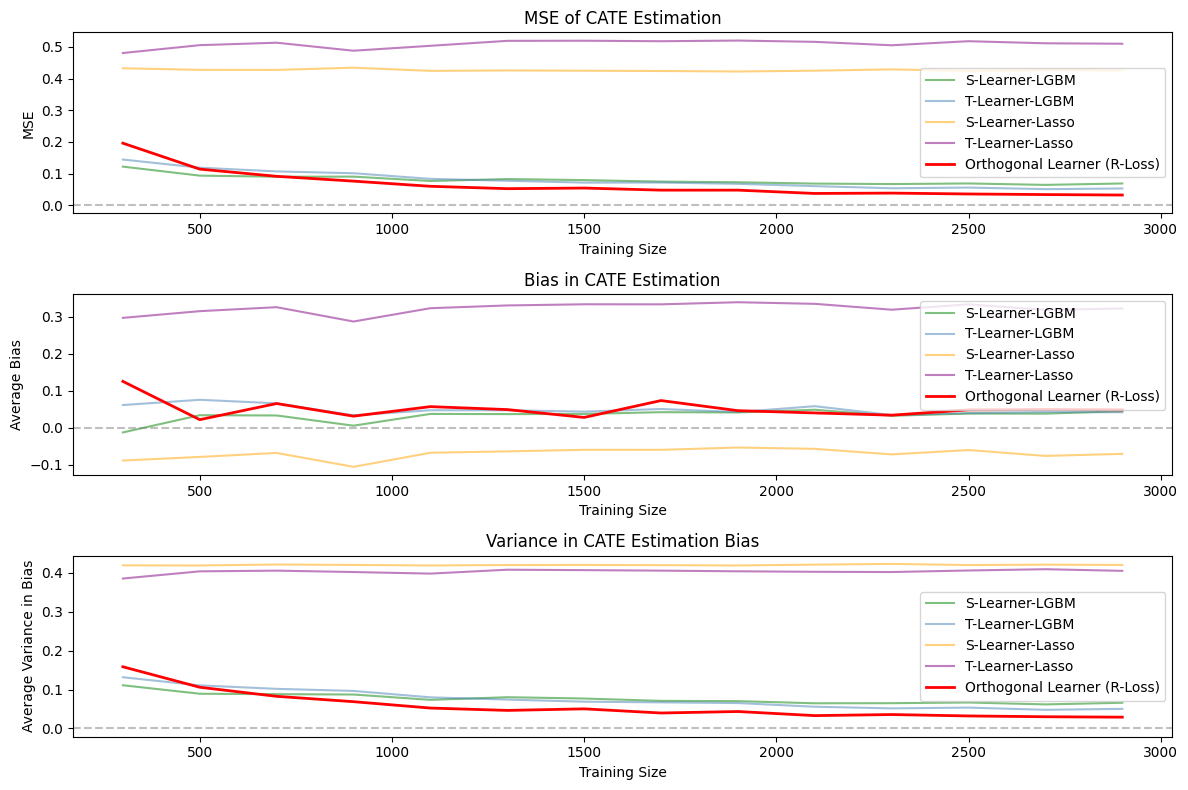

{'mse_s': [0.1217456254010434, 0.09331212906310803, 0.08982234771435622, 0.09013611842300444, 0.07637083556046682, 0.08248140122900735, 0.07917684617507996, 0.07439782722281844, 0.07233909616986416, 0.0681644947607952, 0.06666061614659033, 0.06859527889989106, 0.06406407666984477, 0.06852443761175996], 'mse_t': [0.14410577332046398, 0.11846056957409774, 0.10664140321643328, 0.10085254927755191, 0.08311505206754136, 0.07718198788911881, 0.07124418856192559, 0.07142190699521364, 0.06739550925272252, 0.060130960603074, 0.05337800318211678, 0.05557243266947583, 0.05058152379633603, 0.05265459135891735], 'bias_s': [-0.01278327782721736, 0.03386989755946573, 0.033145455582082074, 0.005493234773484509, 0.03736528221080279, 0.03683342879473627, 0.03731600095693134, 0.04208646682587094, 0.04135069677995159, 0.0486757557069053, 0.03232526703134034, 0.03835935148021656, 0.03811185644572524, 0.044790949043955156], 'bias_t': [0.061425244095707224, 0.07563778989093066, 0.06608347110323701, 0.0336276

In [737]:
# Plot the results in a single figure vertically
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Define plot parameters
metrics = ["mse", "bias", "var"]
titles = [
    "MSE of CATE Estimation",
    "Bias in CATE Estimation",
    "Variance in CATE Estimation Bias",
]
ylabels = ["MSE", "Average Bias", "Average Variance in Bias"]

# Iterate over metrics to plot
for i, metric in enumerate(metrics):
    axes[i].plot(n_list, results[f"{metric}_s"], label="S-Learner-LGBM", color = 'green', linestyle = '-',alpha=0.5)
    axes[i].plot(n_list, results[f"{metric}_t"], label="T-Learner-LGBM", color = 'steelblue', linestyle = '-',alpha=0.5)
    axes[i].plot(n_list, results[f"{metric}_s2"], label="S-Learner-Lasso", color = 'orange', linestyle = '-',alpha=0.5)
    axes[i].plot(n_list, results[f"{metric}_t2"], label="T-Learner-Lasso",  color = 'purple', linestyle = '-',alpha=0.5)
    axes[i].axhline(y=0 if metric != "mse" else 0, color='gray', linestyle='--', alpha=0.5)
    axes[i].plot(n_list, results[f"{metric}_dml"], label="Orthogonal Learner (R-Loss)", color = 'red', linestyle = '-', linewidth = 2)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Training Size")
    axes[i].set_ylabel(ylabels[i])
    axes[i].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

stored_results = results
print(stored_results)

# Change DGP


The result highly depends on DGP. The orthogonal learning rate requires that the variance is not too high in the DGP, and the base learners are close to true DGP models. Also, the improvement compared to S-learner may diminish when CATE are close to 0 (as S-learner tend to bias toward 0) or when the DGP is not too complicated and S-learner base function flexibly captures it (when I use Setup A, with LGBM-S-learner, S-learner actually perform quite well in terms of MSE).

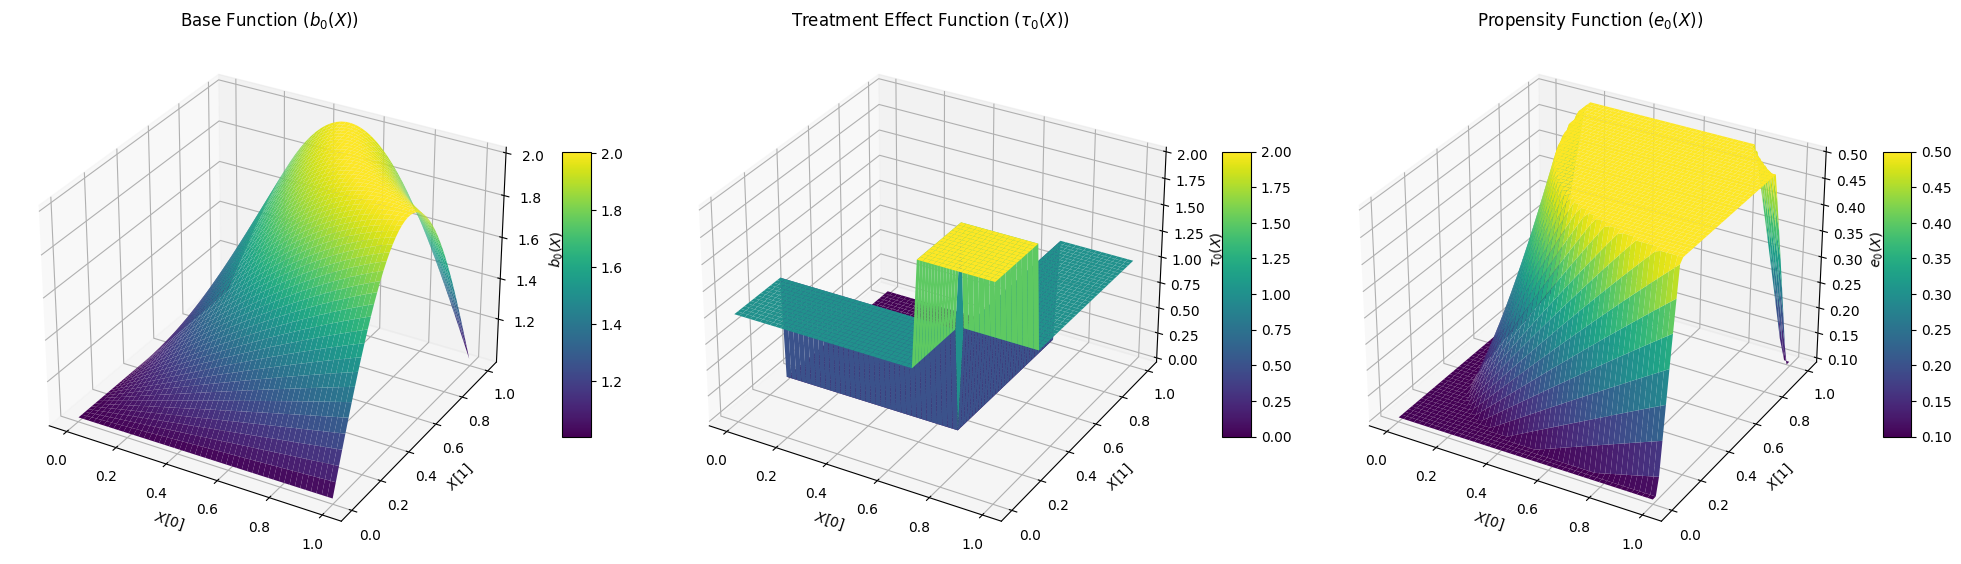

In [752]:
#same dgp, but higher variance
plot_bias(get_data_generator, n_x=4, sigma = 2, n= 500, n_simulation = 300)
plot_convergence(n_list = range(300, 3000, 200), n_simulation=15, sigma = 2)

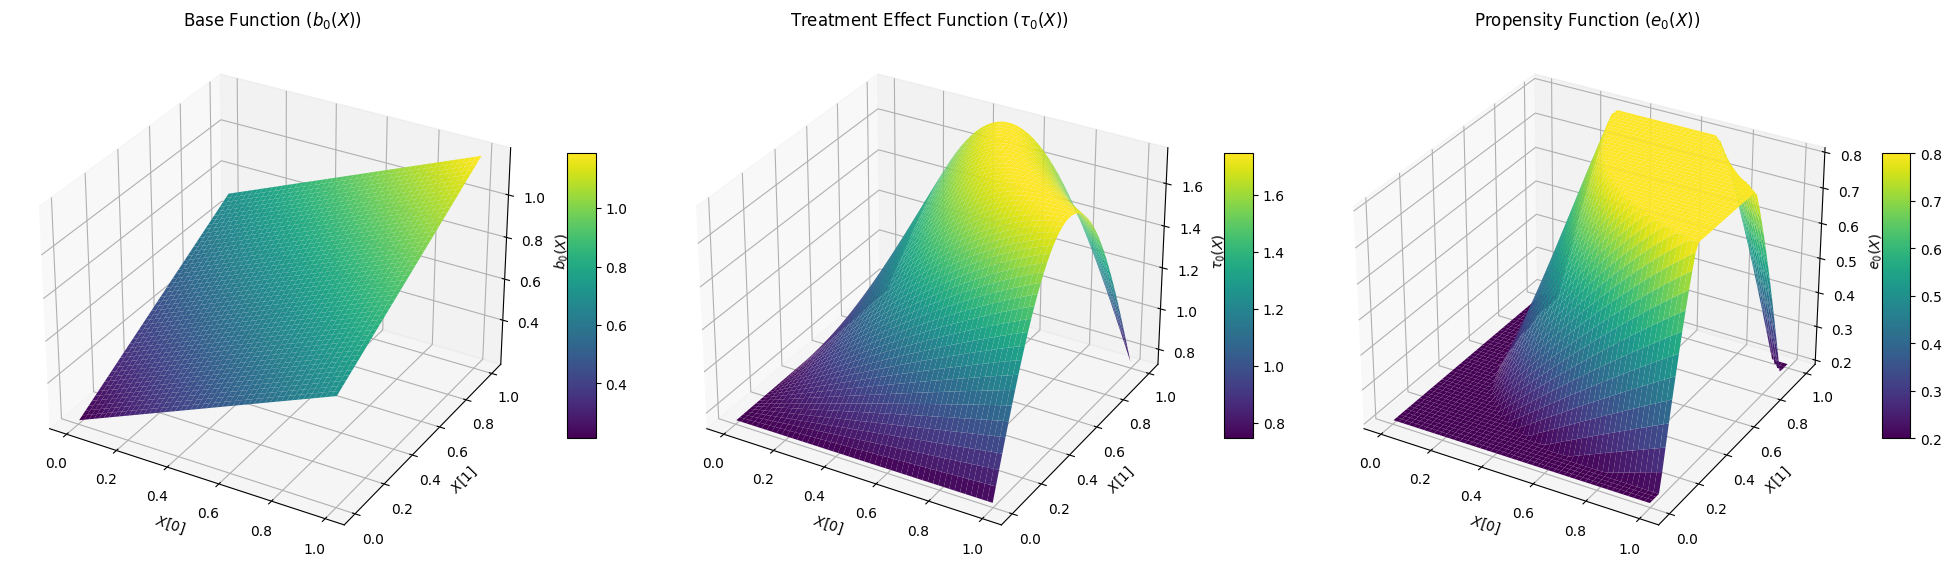

In [741]:
#switch baseline results
def get_data_generator(n, d, sigma):
        def tau_fn(X): return np.sin(np.pi * X[:, 0] * X[:, 1]) + 2*(X[:, 2] - .5)**2 + X[:, 3] + .5*X[:, 4]
        def prop_fn(X): return np.clip(
            np.sin(np.pi * X[:, 0] * X[:, 1]), .2, .8)
        def base_fn(X): return .2 + (X[:, 0] + X[:, 1]) / 2
        def gen_data_fn(): return gen_data(
            n, d, base_fn, tau_fn, prop_fn, sigma)
        return gen_data_fn, base_fn, tau_fn, prop_fn

#plot
plot_dgp(get_data_generator)
plot_bias(get_data_generator, n_x=4, sigma = 0.5, n= 500, n_simulation = 300)
plot_convergence(n_list = range(300, 3000, 200), n_simulation=15, sigma = 0.5)

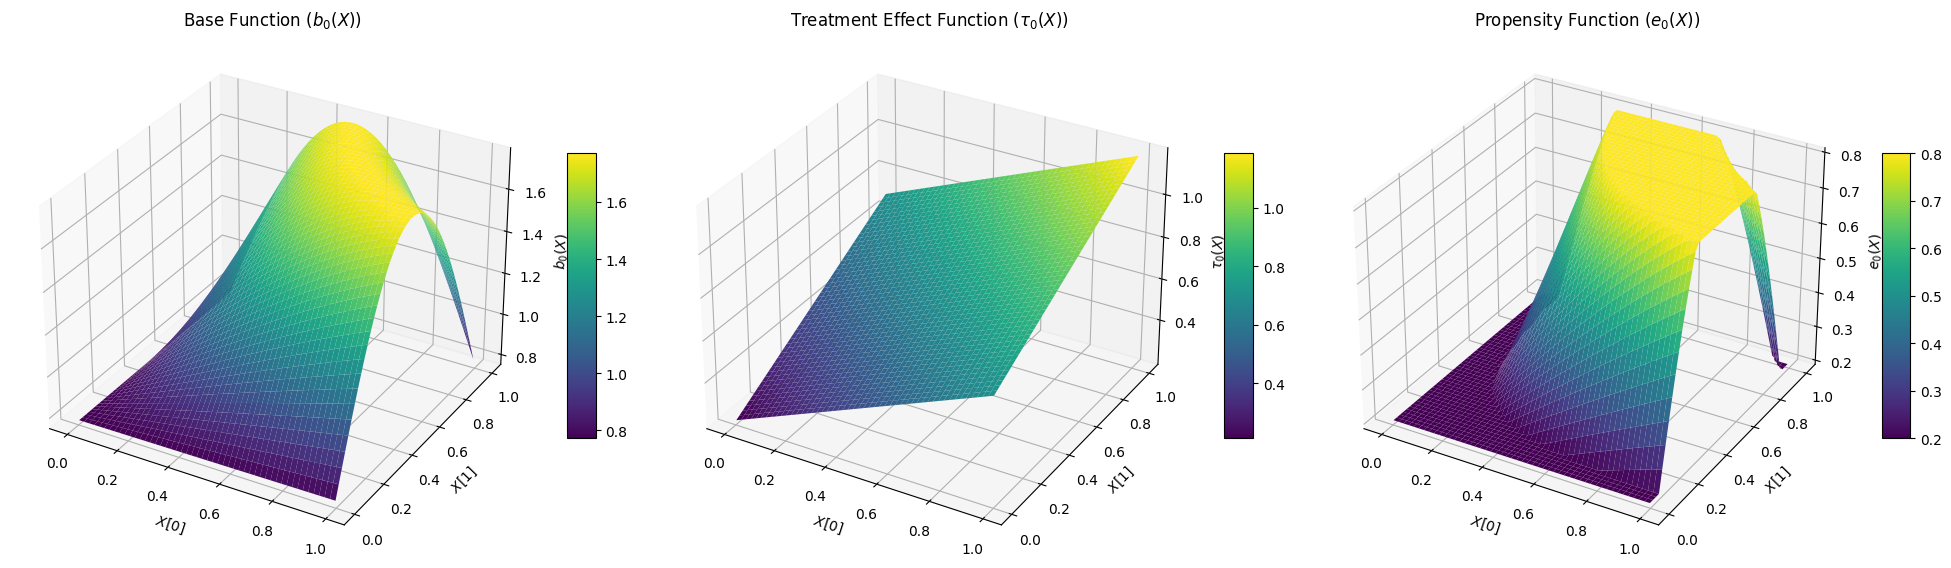

In [742]:
# #original experiment
def get_data_generator(n, d, sigma):
        def base_fn(X): return np.sin(np.pi * X[:, 0] * X[:, 1]) + 2*(X[:, 2] - .5)**2 + X[:, 3] + .5*X[:, 4]
        def prop_fn(X): return np.clip(
            np.sin(np.pi * X[:, 0] * X[:, 1]), .2, .8)
        def tau_fn(X): return .2 + (X[:, 0] + X[:, 1]) / 2
        def gen_data_fn(): return gen_data(
            n, d, base_fn, tau_fn, prop_fn, sigma)
        return gen_data_fn, base_fn, tau_fn, prop_fn

#plot
plot_dgp(get_data_generator)
plot_bias(get_data_generator, n_x=4, sigma = 0.5, n= 500, n_simulation = 300)
plot_convergence(n_list = range(300, 3000, 200), n_simulation=15, sigma = 0.5)
